# Visualizing Spotify Streaming History

## Setting Up

I've already downloaded a JSON file from Spotify containing my streaming history (you can download yours [here](https://www.spotify.com/ca-en/account/privacy/)).

In this section, I will load in the JSON file, convert it into a Pandas data frame, and use the Spotify API to get another data frame containing features (energy, danceability, loudness, etc.) for each song in my streaming history. I will join the two data frames to get a final data frame that I will use for plotting.

In [1]:
## load required packages
import json
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import spotipy.util as util

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot

from math import log
import calmap

from datetime import datetime

In [2]:
## initialize plotly
init_notebook_mode(connected=True)

In [3]:
## load in json file of streaming history
with open('MyData/StreamingHistory0.json', encoding='utf8') as f:
    song_data = json.load(f)
    
song_data[-5:]

[{'endTime': '2020-07-26 03:57',
  'artistName': '朱主愛',
  'trackName': '藏不住的心跳 (《我只喜歡你》影視劇片頭曲)',
  'msPlayed': 71594},
 {'endTime': '2020-07-26 03:59',
  'artistName': 'SBGB',
  'trackName': 'BANANA CHACHA Acoustic',
  'msPlayed': 4800},
 {'endTime': '2020-07-26 03:59',
  'artistName': 'Huh Gak',
  'trackName': 'Let you go (Duet. Jeong Eun Ji)',
  'msPlayed': 92821},
 {'endTime': '2020-07-26 03:59',
  'artistName': 'Stella Jang',
  'trackName': 'YOLO',
  'msPlayed': 8682},
 {'endTime': '2020-07-26 04:01',
  'artistName': '鞠婧禕',
  'trackName': '嘆雲兮(電視劇《芸汐傳》片尾曲)',
  'msPlayed': 101034}]

In [4]:
## convert to dataframe
df = pd.DataFrame(song_data)
df.head()

,endTime,artistName,trackName,msPlayed
0,2018-03-17 04:30,Chef'Special,In Your Arms,215036
1,2019-07-26 12:30,CHANYEOL,Stay With Me,101170
2,2019-07-26 12:34,(G)I-DLE,Senorita,197616
3,2019-07-26 12:38,BLACKPINK,BOOMBAYAH,240848
4,2019-07-26 12:40,EXID,Up & Down,145539


In [5]:
## get user token from spotify to access API (MIGHT BE UNNECESSARY if the following chunk works)
username = 'zihanye96'
client_id ='3ee7d37516aa4d01ad6064f6ce05e5e1' 
client_secret = '68a78f783ce248c783ea1b425f95d88b'
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'

token = util.prompt_for_user_token(username=username, scope=scope, client_id=client_id, client_secret=client_secret,     
                                   redirect_uri=redirect_uri)


In [6]:
## set up access to API
client_id ='3ee7d37516aa4d01ad6064f6ce05e5e1' 
client_secret = '68a78f783ce248c783ea1b425f95d88b'
client_credentials_manager = SpotifyClientCredentials(client_id = client_id, client_secret = client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
sp.trace = False

In [7]:
## get track id of first search result of artist + song title
def get_id(artist, name):
    query = artist + " " + name
    result = sp.search(q=query, limit=1)
    tmp = ""
    for i, t in enumerate(result['tracks']['items']):
        tmp = t["id"]
    return(tmp)

df["id"] = df.apply(lambda x: get_id(x["artistName"], x["trackName"],), axis=1)

In [8]:
df.head()

,endTime,artistName,trackName,msPlayed,id
0,2018-03-17 04:30,Chef'Special,In Your Arms,215036,3wJmcmAh2YAfDSKQR8o1XS
1,2019-07-26 12:30,CHANYEOL,Stay With Me,101170,1POlsQls16ppLPVmr4FGLt
2,2019-07-26 12:34,(G)I-DLE,Senorita,197616,0q6boCcLaWYPIy2vOsksFg
3,2019-07-26 12:38,BLACKPINK,BOOMBAYAH,240848,3yHQKddM8SVCRnuPSo3HPN
4,2019-07-26 12:40,EXID,Up & Down,145539,6BKOhvRPY54uvfqWwg7MKi


In [10]:
ids = list(df["id"].unique())

In [11]:
## get features for each track
features_df = pd.DataFrame(columns=["song_id","energy", "liveness","tempo","speechiness",
                                "acousticness","instrumentalness","danceability",
                                "duration_ms","loudness","valence",
                                "mode","key"])
for song in ids:
    features = sp.audio_features(tracks = [song])[0]
    if features is not None:
        features_df = features_df.append({"song_id":song,
                                    "energy":features['energy'], 
                                    "liveness":features['liveness'],
                                    "tempo":features['tempo'],
                                    "speechiness":features['speechiness'],
                                    "acousticness":features['acousticness'],
                                    "instrumentalness":features['instrumentalness'],
                                    "danceability":features['danceability'],
                                    "duration_ms":features['duration_ms'],
                                    "loudness":features['loudness'],
                                    "valence":features['valence'],
                                    "mode":features['mode'],
                                    "key":features["key"],
                                 },ignore_index=True)
    else:
        pass

In [12]:
## merge tracks with their features
final = pd.merge(df, features_df, how="left", left_on= "id", right_on="song_id")

In [13]:
final.head()

,endTime,artistName,trackName,msPlayed,id,song_id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key
0,2018-03-17 04:30,Chef'Special,In Your Arms,215036,3wJmcmAh2YAfDSKQR8o1XS,3wJmcmAh2YAfDSKQR8o1XS,0.406,0.112,92.964,0.0501,0.64600,0.000013,0.669,215269,-12.186,0.362,1,5
1,2019-07-26 12:30,CHANYEOL,Stay With Me,101170,1POlsQls16ppLPVmr4FGLt,1POlsQls16ppLPVmr4FGLt,0.526,0.126,78.643,0.0484,0.42800,0.000000,0.314,192441,-4.686,0.195,0,0
2,2019-07-26 12:34,(G)I-DLE,Senorita,197616,0q6boCcLaWYPIy2vOsksFg,0q6boCcLaWYPIy2vOsksFg,0.808,0.331,120.021,0.0362,0.01590,0.000043,0.782,197616,-3.139,0.420,1,0
3,2019-07-26 12:38,BLACKPINK,BOOMBAYAH,240848,3yHQKddM8SVCRnuPSo3HPN,3yHQKddM8SVCRnuPSo3HPN,0.836,0.507,124.969,0.0549,0.00264,0.000001,0.658,240849,-3.282,0.387,0,5
4,2019-07-26 12:40,EXID,Up & Down,145539,6BKOhvRPY54uvfqWwg7MKi,6BKOhvRPY54uvfqWwg7MKi,0.812,0.229,112.018,0.0351,0.00189,0.000002,0.714,189882,-2.703,0.377,1,7


## Data Cleaning

Now that we have a dataset containing my history for the previous year and the qualities related to each song that I've streamed, let's clean it up before doing any plotting. The data is already fairly clean, but here are a few things I'll do in addition:

1. Delete any song that wasn't actually streamed (i.e. msPlayed = 0).
2. Convert the feature "msPlayed" (milliseconds played) into minutes
3. Convert the feature "duration_ms" (length of song in milliseconds) into minutes
4. Convert the feature "endTime" (the timestamp when I stopped playing the song) into YYYY-MM-DD format, since I don't plan to do anything with the hour or second information.



In [57]:
## there was a song from 2018 in my streaming history, so I deleted it to keep the time period to 2019-2020
final = final.iloc[1:,]

In [14]:
## delete entries where the song was skipped (i.e. msPlayed = 0)
mask = final["msPlayed"] != 0
final = final[mask].reset_index()

In [23]:
## convert ms to minutes
final["minutesPlayed"] = final["msPlayed"]/60000
final["duration_min"] = final["duration_ms"]/60000

In [45]:
## get a feature representing the date that the song was played
def get_date(date):
    
    date = datetime.strptime(date, '%Y-%m-%d %H:%M')
    return date.strftime("%Y-%m-%d")
    
final["datePlayed"] = final["endTime"].apply(get_date)

In [54]:
## drop defunct/redundant columns
final.drop(columns=['index', 'endTime', 'id', 'msPlayed', 'duration_ms'], inplace=True)

KeyError: "['index' 'endTime' 'id'] not found in axis"

In [72]:
final["minutesPlayed"].describe()

count    5100.000000
mean        1.936962
std         1.638505
min         0.000367
25%         0.141525
50%         1.952167
75%         3.463733
max         6.919117
Name: minutesPlayed, dtype: float64

For some reason, there's a song that was played for 25 minutes (I didn't know songs could be so long!). Let's keep the songs that were played for 0-8 minutes, since anything more than that would likely be an error.

In [70]:
mask = final["minutesPlayed"] <= 8
final = final[mask]

In [79]:
final.head()

,artistName,trackName,song_id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,loudness,valence,mode,key,minutesPlayed,datePlayed,duration_min
1,CHANYEOL,Stay With Me,1POlsQls16ppLPVmr4FGLt,0.526,0.126,78.643,0.0484,0.42800,0.000000,0.314,-4.686,0.195,0,0,1.686167,2019-07-26,3.20735
2,(G)I-DLE,Senorita,0q6boCcLaWYPIy2vOsksFg,0.808,0.331,120.021,0.0362,0.01590,0.000043,0.782,-3.139,0.420,1,0,3.293600,2019-07-26,3.2936
3,BLACKPINK,BOOMBAYAH,3yHQKddM8SVCRnuPSo3HPN,0.836,0.507,124.969,0.0549,0.00264,0.000001,0.658,-3.282,0.387,0,5,4.014133,2019-07-26,4.01415
4,EXID,Up & Down,6BKOhvRPY54uvfqWwg7MKi,0.812,0.229,112.018,0.0351,0.00189,0.000002,0.714,-2.703,0.377,1,7,2.425650,2019-07-26,3.1647
5,TWICE,YES or YES,0Ll92eLIHWY5gey1ISNMPi,0.913,0.166,137.982,0.0374,0.05140,0.000004,0.702,-2.977,0.735,1,11,0.017733,2019-07-26,3.96133


## Data Visualization for Streaming History

Now that I have a data frame containing my history for the previous year and the qualities related to each song that I've streamed, let's visualize some patterns in my streaming history.

### Time Played for Songs I Streamed

Is a Spotify subscription really worth it in my case? A big draw of using Spotify is its algorithm that recommends songs to me. So, to answer the question, I will break down the problem into two parts:

1. Do I like the recommendations that I get?
2. How often do I actually use Spotify?

To answer the first question, I will use the variable "minutesPlayed" as a proxy. I usually skip over songs that I don't like, so if a song was recommended to me and I don't like it, I'll usually skip it.

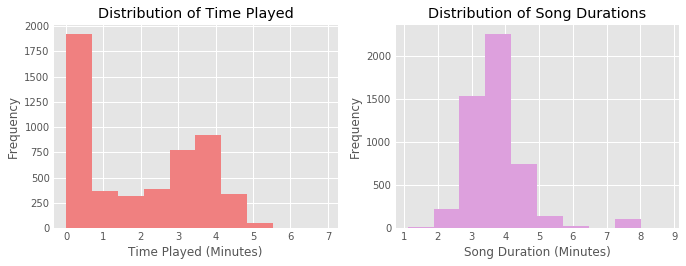

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,3.5))
plt.style.use('ggplot')
ax[0].hist(final["minutesPlayed"], color = "lightcoral", kd)
ax[0].set_xlabel('Time Played (Minutes)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Time Played')


ax[1].hist(final["duration_min"], color = "plum")
ax[1].set_xlabel('Song Duration (Minutes)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Song Durations');

I'm actually quite surprised to see how different the distribution of minutes I streamed a song for is from the distribution of song durations. The latter is roughly normally distributed while the former is right skewed, which goes to show how often I skip over songs. Of the 5000 songs that I streamed in the past year, I listened to about 2000 of them for less than 30 seconds!

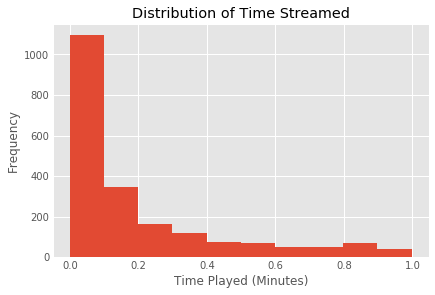

In [108]:
## get the minutes played for songs I played for less than a minute
mask = final["minutesPlayed"]<=1
tmp = final["minutesPlayed"][mask]

plt.hist(tmp)
plt.title("Distribution of Time Streamed")
plt.xlabel('Time Played (Minutes)')
plt.ylabel('Frequency');

Looking just at the songs that I played for less than a minute, it appears that the vast majority of them were skipped after playing for less than 6 seconds! 

Perhaps I should reconsider my Spotify subscription! Skipping about 40% of the songs recommended sounds a bit high to me, and I dislike these recommendations so much that I usually decide to skip in the first 6 seconds of the song. That being said, I can be somewhat picky with music (as you can probably imagine), so it's most likely not the algorithm's fault.

### Trends Throughout Time

In [131]:
aggregate_df = final.groupby('datePlayed').agg({
    'energy': np.mean,
    'liveness': np.mean,
    'tempo': np.mean,
    'speechiness': np.mean,
    'acousticness': np.mean,
    'instrumentalness': np.mean,
    'danceability': np.mean,
    'loudness': np.mean,
    'valence': [np.mean, np.std],
    'minutesPlayed': np.sum
        })

## rename column names to the following format: feature_aggregate function
aggregate_df.columns = ['_'.join(name) for name in aggregate_df.columns]
aggregate_df.reset_index(inplace=True)

In [143]:
aggregate_df.head()

,datePlayed,energy_mean,liveness_mean,tempo_mean,speechiness_mean,acousticness_mean,instrumentalness_mean,danceability_mean,loudness_mean,valence_mean,valence_std,minutesPlayed_sum
0,2019-07-26,0.825902,0.183923,124.182213,0.071423,0.138269,0.000515,0.699393,-3.322475,0.581016,0.216436,81.651333
1,2019-07-27,0.682670,0.199070,130.041522,0.089304,0.266054,0.043547,0.606043,-5.659391,0.495174,0.194936,48.240333
2,2019-07-28,0.839118,0.178918,123.047706,0.068676,0.117122,0.000682,0.717235,-3.142824,0.598941,0.210349,36.503783
3,2019-07-29,0.855053,0.209914,127.664719,0.142035,0.087242,0.055553,0.684351,-3.432333,0.534298,0.199184,92.692833
4,2019-07-30,0.841174,0.197309,125.604609,0.072365,0.123319,0.000343,0.710565,-3.028870,0.584826,0.201651,24.517983


There are two features I'm particularly interested in looking at. In the aggregated data frame, I have the total daily minutes played, as well as the average "valence" of the songs I played during that day. According to Spotify, valence is	a feature that describes "the musical positiveness conveyed by a track". Valence ranges from 0-1, with 1 being more upbeat and 0 being more sad. By looking at valence over time, I can see how my mood changed throughout the past year.

In [153]:
aggregate_df["date"] = pd.to_datetime(aggregate_df['datePlayed'], format='%Y-%m-%d')
#aggregate_df["date"] = aggregate_df['datePlayed'].apply(lambda x:x[:7])

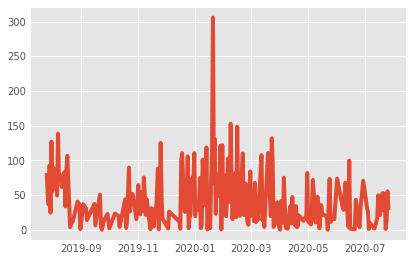

In [156]:
plt.plot(aggregate_df["date"], aggregate_df["minutesPlayed_sum"])

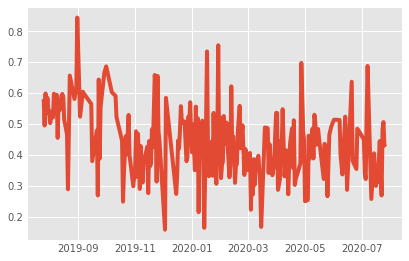

In [155]:
plt.plot(aggregate_df["date"], aggregate_df["valence_mean"])

### Bonus: Using Machine Learning to Generate Better Recommendations
Since I noticed the Spotify algorithm isn't really working for me, I'd like to try to build a model that can better feel out my tastes. I have low expectations for this since Spotify has a dedicated data science team full of more experienced data scientists, but let's see how it goes.